In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

# Graphs

- $\frac{dT}{dt} = T + h * T + a \cdot log(V) + b \cdot log(W) = h \cdot T + \log(V^a \cdot W^b)$
- $\frac{dW}{dt} = W$
- $\frac{dV}{dt} = a \cdot V +b \cdot e^{(-\frac{(T-T_0*d)^2}{c})}$

In [2]:
t_max = 50
t_min= 20
t_crit = 40
h = 0.1
W = 0.5
p = 0.1

In [5]:
data = pd.read_csv("../data/yearly_p_t_v_wide.csv")
data = data[data["country"] == "Germany"]
##data = data.pivot(columns=["variable"], values=["value"],index="city").reset_index()
##data.columns = ["city","PM2.5 (μg/m3)", "V", "T", "W"]
#data = data.loc[:,["city","PM2.5 (μg/m3)", "V", "T", "W"]].groupby("city").mean()
#data.columns = ["P", "V", "T", "W"]
#data = data.dropna()

In [6]:
data

,country,year,city,val_idx,V,P,T
0,Germany,2002,Berlin,1,906.285899,28.000000,9.844027
1,Germany,2002,Bremen,1,1460.106010,28.000000,10.051041
2,Germany,2002,Dortmund,1,53.021105,29.000000,10.429123
3,Germany,2002,Dresden,1,430.816843,32.000000,9.225726
4,Germany,2002,Frankfurt,1,253.717734,30.500000,10.529425
...,...,...,...,...,...,...,...
112,Germany,2014,Frankfurt,13,253.736430,21.500000,11.429452
113,Germany,2014,Leipzig,13,304.170393,26.333333,11.017699
114,Germany,2014,Mannheim,13,103.466212,18.000000,11.781699
115,Germany,2014,München,13,1601.125459,20.500000,10.273151


## Temp vs Particulates + Vegetation

In [105]:
def fit_function(data, f, y):
    na_data = ~y.isna()
    data = data.loc[na_data, :]
    y = y[na_data]
    popt_linear, _ = curve_fit(f, data, y)
    return popt_linear

def plot_paras(data, in_var, target_var, res_paras, fixed_vars, n_col = 3, n_row = 3):
    fig, axs = plt.subplots(n_row, n_col, figsize = (10, 10))
    for cur_col in range(n_col):
        for cur_row in range(n_row):
            cur_df_id = cur_col * n_col + cur_row
            cur_x = cur_col
            cur_y = cur_row
            cur_paras = res_paras[cur_df_id]
            cur_df = data[cur_df_id][1]
            fixed_para = [cur_df[cur_fixed_var].mean() for cur_fixed_var in fixed_vars]
            free_var = [cur_var for cur_var in in_var if cur_var not in fixed_vars][0]
            axs[cur_x, cur_y].scatter(cur_df[free_var],
                cur_df[target_var], marker = "x", label = "Data")
            plot_data = dict(zip(fixed_vars, fixed_para))
            plot_data[free_var[0]] = cur_df[free_var]
            axs[cur_x, cur_y].plot(cur_df[free_var],dt_linear(pd.DataFrame(plot_data), *cur_paras),
                label = "pred", color = "orange")
            axs[cur_x, cur_y].legend()
            axs[cur_x, cur_y].set_title(cities_df[cur_df_id][0])

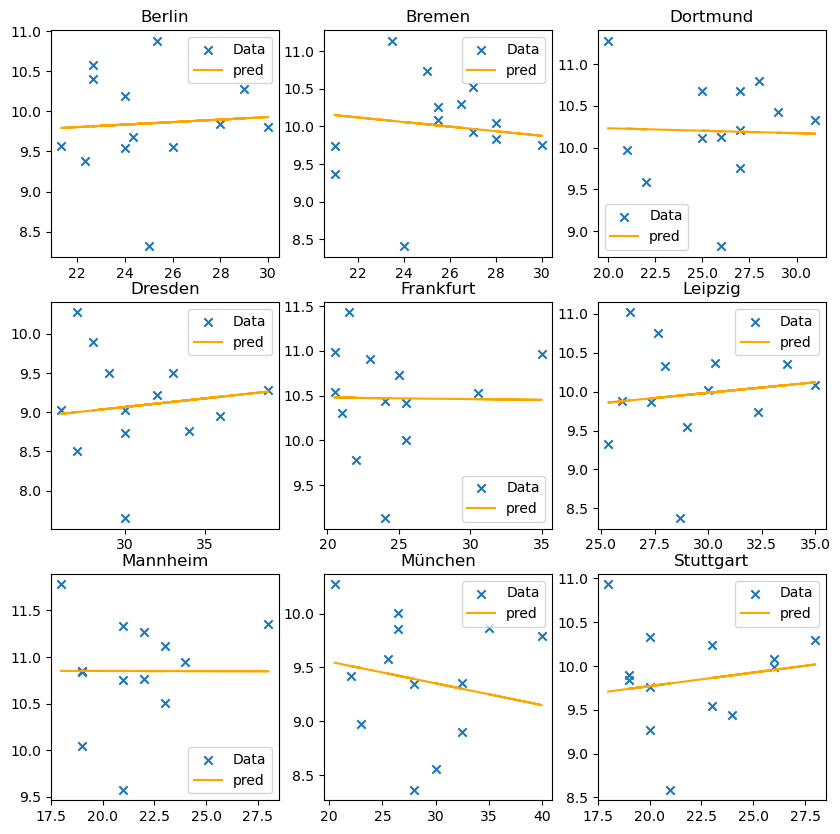

In [96]:
# fit over time
# Function candidates
in_var = ["P", "V"]
target_var = "T"

def dt_linear(VP, h, c):
    V, P = VP["V"], VP["P"]
    return h*P - c*V 

res_paras = [fit_function(cur_df[1].loc[:, in_var], dt_linear, cur_df[1][target_var].shift(-1)) for cur_df in data.groupby("city")]

plot_paras(cities_df, in_var, target_var, res_paras, fixed_vars=["V"])

<Axes: xlabel='variable', ylabel='value'>

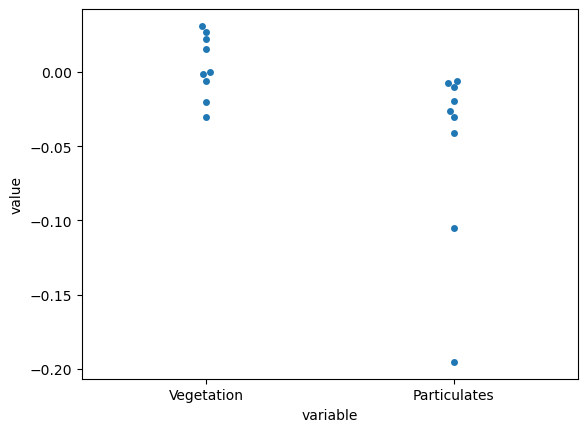

In [68]:
t_paras_df = pd.DataFrame(res_paras)
t_paras_df.columns = ["Vegetation", "Particulates"]
sns.swarmplot(x="variable", y="value", data = pd.melt(t_paras_df))

## Particulates VS Temperature & Vegetation

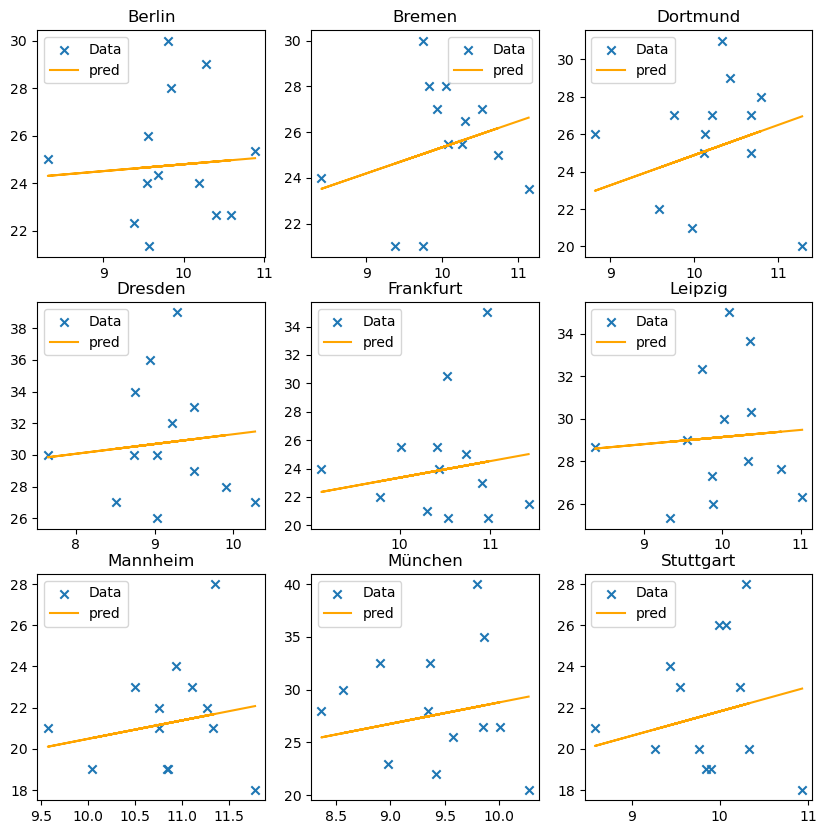

In [91]:
in_var = ["P", "T", "V"]
target_var = "P"
def dt_linear(PTV , p, r):
    P, T, V = [PTV[cur_var] for cur_var in in_var]
    return  p * P * T - r * V

res_paras = [fit_function(cur_df[1].loc[:, in_var], dt_linear, cur_df[1][target_var].shift(-1)) for cur_df in data.groupby("city")]
plot_paras(cities_df, in_var, target_var, res_paras, fixed_vars=["V", "P"])

<Axes: xlabel='variable', ylabel='value'>

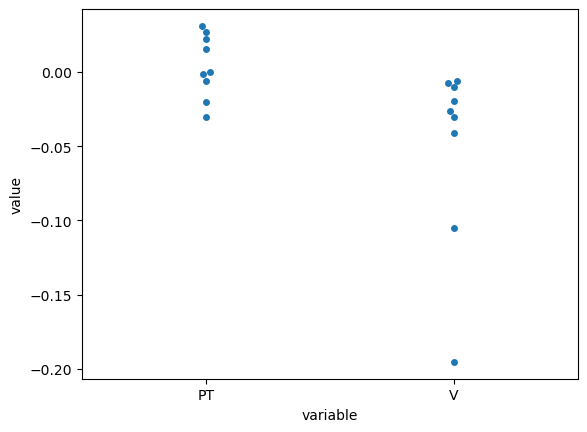

In [97]:
t_paras_df = pd.DataFrame(res_paras)
t_paras_df.columns = ["PT", "V"]
sns.swarmplot(x="variable", y="value", data = pd.melt(t_paras_df))

## Water vs Temp

[ 4.93823918e+02 -7.12765564e+02 -4.63552030e-02]


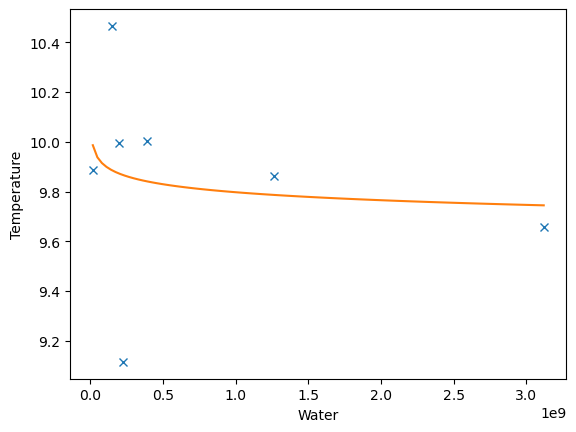

In [19]:
# Function candidates
def dt(W, h, a, b):
    T = data["T"].mean()
    V = data["V"].mean()
    return T + h * T + a * np.log(V) + b * np.log(W)

# Perform the curve fitting
popt, pcov = curve_fit(dt, data["W"], data["T"])

x_fit = np.linspace(min(data["W"]), max(data["W"]), 100)
y_fit = dt(x_fit, *popt)

plt.plot(data["W"],data["T"],"x")
plt.plot(x_fit,y_fit)
plt.ylabel("Temperature")
plt.xlabel("Water")
print(popt)

## Vegetation vs Temp

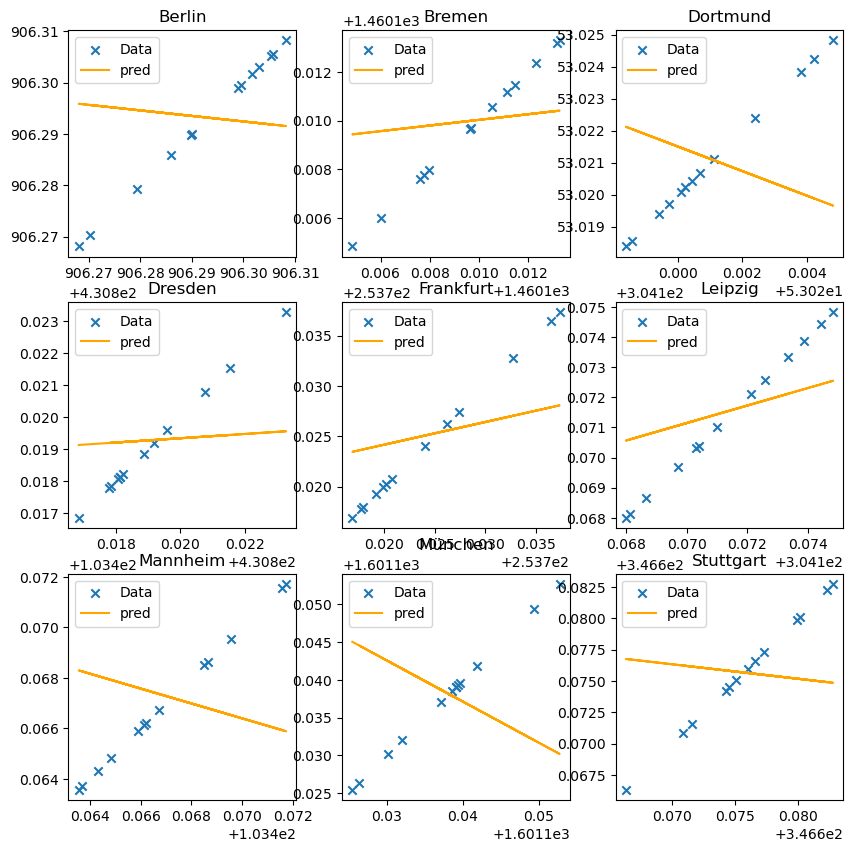

In [106]:
# Function candidates

in_var = ["V"]
target_var = "V"
def dt_linear(V , s, g):
    V = V["V"]
    return s + g*V

res_paras = [fit_function(cur_df[1].loc[:, in_var], dt_linear, cur_df[1][target_var].shift(-1)) for cur_df in data.groupby("city")]
plot_paras(cities_df, in_var, target_var, res_paras, fixed_vars=[])

<Axes: xlabel='variable', ylabel='value'>

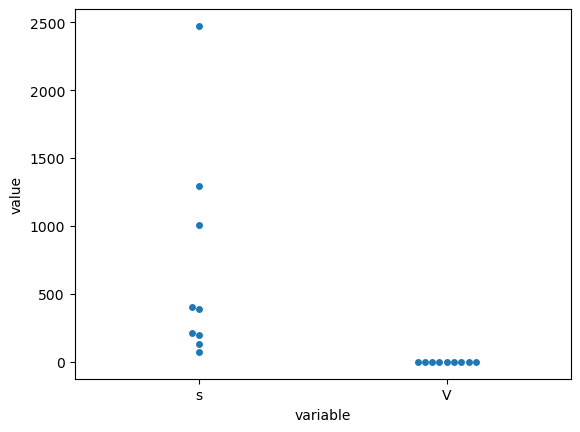

In [108]:
t_paras_df = pd.DataFrame(res_paras)
t_paras_df.columns = ["s", "V"]
sns.swarmplot(x="variable", y="value", data = pd.melt(t_paras_df))

bell: [4.88491687e-01 2.61605977e+03 3.45681363e-02 9.69686654e-01]


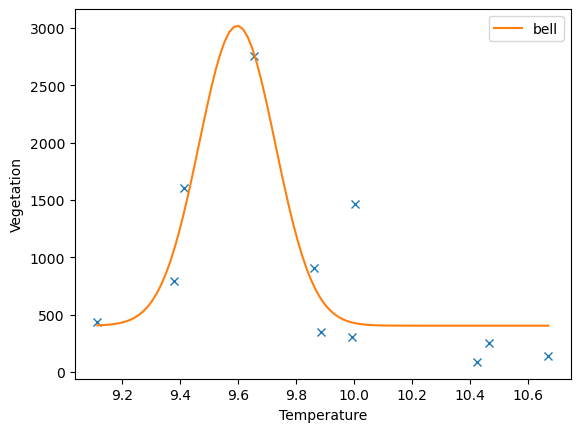

In [7]:
# Function candidates
def dV_bell(T, a, b, c, d):
    mean_temp = data["T"].mean()
    mean_v = data["V"].mean()
    return a*mean_v+b*np.exp(-((T - mean_temp*d)**2)/c)

# Perform the curve fitting
popt_bell, pcov_bell = curve_fit(dV_bell, data["T"], data["V"], bounds=([-np.inf,-np.inf, -np.inf, -1], [np.inf, np.inf, np.inf, 1]),
                                p0 =[1, 1000, 1, 1])

x_fit = np.linspace(min(data["T"]), max(data["T"]), 100)
y_fit_bell = dV_bell(x_fit, *popt_bell)

plt.plot(data["T"],data["V"],"x")
plt.plot(x_fit,y_fit_bell, label="bell")
plt.xlabel("Temperature")
plt.ylabel("Vegetation")
plt.legend(loc="best")
print("bell:",popt_bell)

# Diff systems parameter approximation

In [246]:
import numpy as np
from scipy.optimize import minimize

# Assume data is given as numpy arrays
# t: time array
# T, P, V: observed data arrays for temperature, pressure, and volume respectively
t = data["year"].unique()
values = []
for name, city in data.groupby("city"):
    T = city["T"]
    P = city["P"]
    V = city["V"]

    # Compute numerical derivatives using finite differences
    dT_dt = np.gradient(T, t)
    dP_dt = np.gradient(P, t)
    dV_dt = np.gradient(V, t)

    # Define the objective function to minimize
    def objective(params):
        h, c, p, r, s, g = params
        residuals_T = dT_dt - (h * P - c * V)
        residuals_P = dP_dt - (p * P * T - r * V)
        residuals_V = dV_dt - (s + g * V)
        
        # Sum of squared residuals
        return np.sum(residuals_T**2 + residuals_P**2 + residuals_V**2)

    # Initial guess for the parameters
    initial_guess = [1, 1, 1, 1, 1, 1]

    # Perform the optimization
    result = minimize(objective, initial_guess)

    # Extract the optimized parameters
    h_opt, c_opt, p_opt, r_opt, s_opt, g_opt = result.x

    values.append([name, h_opt, c_opt, p_opt, r_opt, s_opt, g_opt])

data_param = pd.DataFrame(values, columns=["city","h","c","p","r","s","g"])
# print("Optimized parameters:")
# print(f"h: {h_opt}")
# print(f"c: {c_opt}")
# print(f"p: {p_opt}")
# print(f"r: {r_opt}")
# print(f"s: {s_opt}")
# print(f"g: {g_opt}")
data_param = pd.merge(data_param,
                      data.groupby("city")[["T","P","V"]].mean().reset_index(),
                      on="city")

/tmp/ipykernel_49645/527442142.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(0,row[1+j], marker=markers[i%3],linestyle="",color=colors[i])
/tmp/ipykernel_49645/527442142.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(0,row[1+j], marker=markers[i%3],linestyle="",color=colors[i])
/tmp/ipykernel_49645/527442142.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(0,row[1+j], marker=markers[i%3],line

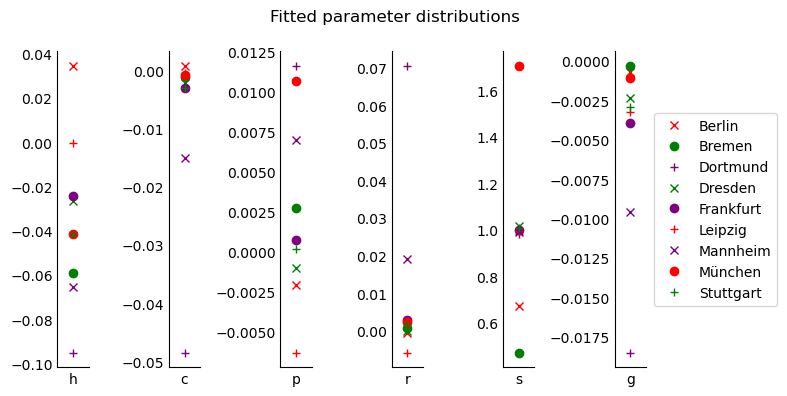

In [251]:
colors = ["red","green","purple","green","purple","red","purple","red","green"]
markers = ["x","o","+"]
fig, axes = plt.subplots(1,6,figsize=(8,4))
for i, row in data_param.iterrows():
    for j, ax in enumerate(axes):
        if j == 5:
            ax.plot(0,row[1+j],label=row["city"], marker=markers[i%3],linestyle="",color=colors[i])
            ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
        else:
            ax.plot(0,row[1+j], marker=markers[i%3],linestyle="",color=colors[i])
        ax.set_xticks([0],labels=[list(row.index)[1+j]])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='both', length=0) 
fig.suptitle("Fitted parameter distributions")
fig.tight_layout();

In [254]:
# Left eigenvalues
def normalize(v):
    v_sum = np.sum([abs(i) for i in v if not np.isnan(i)])
    return np.array([i / v_sum if not np.isnan(i) else i for i in v])

def complex_sqrt(values):
    values = np.asarray(values, dtype=complex)  # Ensure values are treated as complex
    return np.sqrt(values)

def compute_u1():
    return np.array([0, 0, 1])

def compute_u2(c, g, h, p, P, r, T):
    u2_1 = (2 * h * p * P + g * p * T + g * complex_sqrt(8 * h * p * P + p**2 * T**2)) / (-4 * h * r + c * p * T + c * complex_sqrt(8 * h * p * P + p**2 * T**2))
    u2_2 = (0.25 * h * (4 * g - p * T + complex_sqrt(8 * h * p * P + p**2 * T**2))) / (h * r - 0.25 * c * p * T - 0.25 * c * complex_sqrt(8 * h * p * P + p**2 * T**2))
    u2 = np.array([u2_1, u2_2, 1])
    # Normalize u2 to ensure it sums up to 1
    return u2 #/ np.sum(u2)

def compute_u3(c, g, h, p, P, r, T):
    u3_1 = (-2 * h * p * P - g * p * T + g * np.sqrt(8 * h * p * P + p**2 * T**2)) / (4 * h * r - c * p * T + c * np.sqrt(8 * h * p * P + p**2 * T**2))
    u3_2 = (-0.25 * h * (-4 * g + p * T + np.sqrt(8 * h * p * P + p**2 * T**2))) / (h * r - 0.25 * c * p * T + 0.25 * c * np.sqrt(8 * h * p * P + p**2 * T**2))
    u3 = np.array([u3_1, u3_2, 1])
    # Normalize u3 to ensure it sums up to 1
    return normalize(u3) #/ np.sum(u3)

def compute_v1(c, g, h, p, P, r, T):
    v1_1 = -(2 * c * g + 2 * h * r - c * p * T) / (2 * g**2 - h * p * P - g * p * T)
    v1_2 = -(-c * p * P - 2 * g * r) / (-2 * g**2 + h * p * P + g * p * T)
    return np.array([v1_1, v1_2, 1]) #/ np.sum([v1_1, v1_2, 1])

def compute_v2(p, h, P, T):
    v2_1 = - (np.sqrt(p) * T + np.sqrt(8 * h * P + p * T**2)) / (2 * np.sqrt(p) * P)
    return np.array([v2_1, 1, 0]) #/ np.sum(np.array([v2_1, 1, 0]) )

def compute_v3(p, h, P, T):
    v3_1 = - (np.sqrt(p) * T - np.sqrt(8 * h * P + p * T**2)) / (2 * np.sqrt(p) * P)
    return np.array([v3_1, 1, 0]) #/ np.sum(np.array([v3_1, 1, 0]))
# Eigenvalues
def compute_lambda1(g):
    return g

def compute_lambda2(p, h, P, T):
    term = np.sqrt(p) * np.sqrt(8 * h * P + p * T**2)
    return 1/4 * (p * T - term)

def compute_lambda3(p, h, P, T):
    term = np.sqrt(p) * np.sqrt(8 * h * P + p * T**2)
    return 1/4 * (term + p * T)

In [253]:
# Equilibria
data_param["T_equ"] = data_param.apply(lambda x: x["h"]*x["r"]/x["c"]/x["p"],axis=1) 
data_param["P_equ"] = data_param.apply(lambda x: - x["c"]*x["s"]/x["g"]/x["h"],axis=1) 
data_param["V_equ"] = data_param.apply(lambda x: -x["s"]/x["g"],axis=1) 
# Left eigenvector
data_param["u_1"] = data_param.apply(lambda x: compute_u1(),axis=1)
data_param["u_2"] = data_param.apply(lambda x: compute_u2(x["c"],x["g"],x["h"],x["p"],x["P_equ"],x["r"],x["T_equ"]),axis=1)
data_param["u_3"] = data_param.apply(lambda x: compute_u3(x["c"],x["g"],x["h"],x["p"],x["P_equ"],x["r"],x["T_equ"]),axis=1)
# Right eigenvectors
data_param["v_1"] = data_param.apply(lambda x: compute_v1(x["c"],x["g"],x["h"],x["p"],x["P"],x["r"],x["T"]),axis=1)
data_param["v_2"] = data_param.apply(lambda x: compute_v2(x["p"],x["h"],x["P_equ"],x["T_equ"]),axis=1)
data_param["v_3"] = data_param.apply(lambda x: compute_v3(x["p"],x["h"],x["P_equ"],x["T_equ"]),axis=1)
# Eigenvalues
data_param["e_1"] = data_param.apply(lambda x: compute_lambda1(x["g"]),axis=1)
data_param["e_2"] = data_param.apply(lambda x: compute_lambda2(x["p"],x["h"],x["P_equ"],x["T_equ"]),axis=1)
data_param["e_3"] = data_param.apply(lambda x: compute_lambda3(x["p"],x["h"],x["P_equ"],x["T_equ"]),axis=1)

/tmp/ipykernel_49645/1258886383.py:21: RuntimeWarning: invalid value encountered in sqrt
  u3_1 = (-2 * h * p * P - g * p * T + g * np.sqrt(8 * h * p * P + p**2 * T**2)) / (4 * h * r - c * p * T + c * np.sqrt(8 * h * p * P + p**2 * T**2))
/tmp/ipykernel_49645/1258886383.py:22: RuntimeWarning: invalid value encountered in sqrt
  u3_2 = (-0.25 * h * (-4 * g + p * T + np.sqrt(8 * h * p * P + p**2 * T**2))) / (h * r - 0.25 * c * p * T + 0.25 * c * np.sqrt(8 * h * p * P + p**2 * T**2))
/tmp/ipykernel_49645/1258886383.py:33: RuntimeWarning: invalid value encountered in sqrt
  v2_1 = - (np.sqrt(p) * T + np.sqrt(8 * h * P + p * T**2)) / (2 * np.sqrt(p) * P)
/tmp/ipykernel_49645/1258886383.py:37: RuntimeWarning: invalid value encountered in sqrt
  v3_1 = - (np.sqrt(p) * T - np.sqrt(8 * h * P + p * T**2)) / (2 * np.sqrt(p) * P)
/tmp/ipykernel_49645/1258886383.py:44: RuntimeWarning: invalid value encountered in sqrt
  term = np.sqrt(p) * np.sqrt(8 * h * P + p * T**2)
/tmp/ipykernel_49645/12588863

In [184]:
data_param

,city,h,c,p,r,s,g,T,P,V,...,V_equ,u_1,u_2,u_3,v_1,v_2,v_3,e_1,e_2,e_3
0,Berlin,0.034418,0.000798,-0.002093,-0.000554,0.671960,-0.000739,9.849523,24.974359,906.292777,...,908.855911,"[0, 0, 1]","[nan, nan, 1.0]","[nan, nan, 1.0]","[0.012814237090769514, 0.02290936123290764, 1.0]","[nan, 1.0, 0.0]","[nan, 1.0, 0.0]",-0.000739,NaN,NaN
1,Bremen,-0.059304,-0.001133,0.002721,0.000595,0.468761,-0.000320,10.010285,25.538462,1460.109661,...,1462.615848,"[0, 0, 1]","[nan, nan, 1.0]","[nan, nan, 1.0]","[0.00944837169833437, 0.01916205544588537, 1.0]","[nan, 1.0, 0.0]","[nan, 1.0, 0.0]",-0.000320,NaN,NaN
2,Dortmund,-0.095203,-0.048532,0.011605,0.070486,0.981276,-0.018511,10.214221,25.692308,53.021067,...,53.011202,"[0, 0, 1]","[nan, nan, 1.0]","[nan, nan, 1.0]","[0.18778927391935238, 0.546286264042894, 1.0]","[nan, 1.0, 0.0]","[nan, 1.0, 0.0]",-0.018511,NaN,NaN
3,Dresden,-0.026771,-0.002237,-0.001019,-0.000128,1.014423,-0.002354,9.102806,30.846154,430.819096,...,430.893295,"[0, 0, 1]","[-0.42596872068993097, -0.5235212975560891, 0....","[0.4398175103815381, -0.5221844480563175, 0.03...","[-0.003948869391644317, 0.08322258578095551, 1.0]","[nan, 1.0, 0.0]","[nan, 1.0, 0.0]",-0.002354,NaN,NaN
4,Frankfurt,-0.024315,-0.002933,0.000717,0.002847,0.996731,-0.003920,10.474919,24.461538,253.724360,...,254.241253,"[0, 0, 1]","[nan, nan, 1.0]","[nan, nan, 1.0]","[0.19193870055579298, 0.15156270936314015, 1.0]","[nan, 1.0, 0.0]","[nan, 1.0, 0.0]",-0.003920,NaN,NaN
5,Leipzig,-0.000442,-0.000515,-0.006327,-0.005892,0.992978,-0.003264,9.974156,29.205128,304.171333,...,304.258095,"[0, 0, 1]","[-0.9501546160037633, -0.019955391998666784, 0...","[0.9658257951315105, -0.0181069802686525, 0.01...","[-0.08979490033185208, 0.5015631264405885, 1.0]","[nan, 1.0, 0.0]","[nan, 1.0, 0.0]",-0.003264,NaN,NaN
6,Mannheim,-0.065522,-0.015059,0.006977,0.019128,0.990076,-0.009567,10.856736,21.538462,103.467029,...,103.485662,"[0, 0, 1]","[nan, nan, 1.0]","[nan, nan, 1.0]","[0.10022054258659206, 0.2444671373669462, 1.0]","[nan, 1.0, 0.0]","[nan, 1.0, 0.0]",-0.009567,NaN,NaN
7,München,-0.041706,-0.000791,0.010666,0.002419,1.706757,-0.001067,9.408093,28.461538,1601.137737,...,1599.768790,"[0, 0, 1]","[nan, nan, 1.0]","[nan, nan, 1.0]","[0.00945553640698777, 0.019196676712487506, 1.0]","[nan, 1.0, 0.0]","[nan, 1.0, 0.0]",-0.001067,NaN,NaN
8,Stuttgart,-0.041705,-0.003057,0.000158,0.001874,1.007695,-0.002909,9.862416,22.076923,346.675951,...,346.415687,"[0, 0, 1]","[nan, nan, 1.0]","[nan, nan, 1.0]","[0.8024246987296216, 0.12926875128750842, 1.0]","[nan, 1.0, 0.0]","[nan, 1.0, 0.0]",-0.002909,NaN,NaN


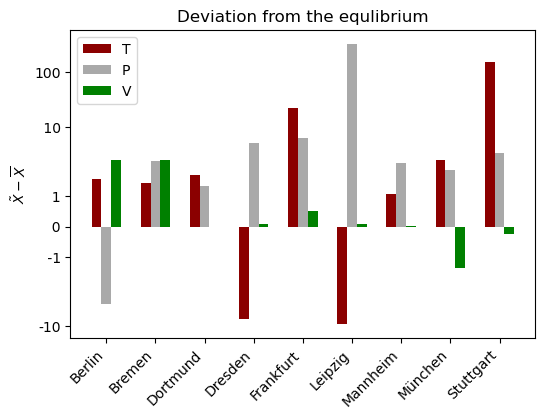

In [241]:
from matplotlib import ticker
X_axis = np.arange(len(data_param["city"]))

fig, axes = plt.subplots(figsize=(6,4))
plt.bar(X_axis - 0.2,data_param["T_equ"]-data_param["T"], 0.2, label = 'T', color="darkred") 
plt.bar(X_axis,data_param["P_equ"]-data_param["P"], 0.2, label = 'P', color="darkgrey") 
plt.bar(X_axis + 0.2, data_param["V_equ"]-data_param["V"], 0.2, label = 'V', color="green")
plt.legend() 
#plt.ylim(-15,25)
plt.yscale("symlog")
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter("%3d"))
plt.ylabel(r"$\tilde{X}-\overline{X}$")
plt.title("Deviation from the equlibrium")
plt.xticks(range(9),data_param["city"],rotation=45, ha='right');